# DATA CLEANING

In [627]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from windrose import WindroseAxes
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit
from bokeh.plotting import figure, show

In [628]:
#read csv
df1 = pd.read_csv('data/Location1.csv')
df1.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [629]:
df1.describe()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,47.862911,72.288744,38.569308,3.591147,6.284431,203.637329,203.343676,7.771795,0.405385
std,19.453691,16.852287,18.772110,1.649318,2.685216,96.371262,97.959852,3.569147,0.288322
min,-14.400000,18.000000,-17.100000,0.000000,0.100000,1.000000,0.000000,0.500000,0.000000
25%,32.100000,60.000000,24.300000,2.410000,4.380000,132.000000,130.000000,5.000000,0.148900
50%,47.300000,74.000000,38.100000,3.300000,6.080000,225.000000,226.000000,7.200000,0.347650
75%,64.500000,86.000000,54.700000,4.590000,7.990000,277.000000,278.000000,10.000000,0.659600
max,94.100000,100.000000,76.300000,13.450000,20.650000,360.000000,360.000000,29.200000,0.991300


In [630]:
#Check row count - 5 years of hourly data
total_hours = 24*365*5
total_hours == len(df1)

True

1) No. of rows match the no. of hours in 5 years, no missing rows
2) Temperature min/max suggests the temperature must be in Fahrenheit. Std Dev seems to be fair since weather can fluctuate through seasons.
3) Wind Direction min/max suggests the column must be in Degrees
4) Power column in normalized between 0-1 (with 1 being max capacity)

In [631]:
#Renamimg columns
df1 = df1.rename(columns={'Time':'time','Power':'power'})
df1

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793
...,...,...,...,...,...,...,...,...,...,...
43795,2021-12-31 19:00:00,34.1,94,32.5,1.00,1.91,53,137,2.5,0.1796
43796,2021-12-31 20:00:00,34.8,94,33.4,2.52,4.30,56,72,4.8,0.2066
43797,2021-12-31 21:00:00,34.1,95,33.0,1.10,1.84,360,45,4.3,0.2336
43798,2021-12-31 22:00:00,34.4,96,33.5,2.40,4.62,45,51,4.2,0.2606


In [632]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 43800 non-null  object 
 1   temperature_2m       43800 non-null  float64
 2   relativehumidity_2m  43800 non-null  int64  
 3   dewpoint_2m          43800 non-null  float64
 4   windspeed_10m        43800 non-null  float64
 5   windspeed_100m       43800 non-null  float64
 6   winddirection_10m    43800 non-null  int64  
 7   winddirection_100m   43800 non-null  int64  
 8   windgusts_10m        43800 non-null  float64
 9   power                43800 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 3.3+ MB


In [633]:
#change Time column to datetime format
df1 = df1.astype({'time':'datetime64[ns]'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 43800 non-null  datetime64[ns]
 1   temperature_2m       43800 non-null  float64       
 2   relativehumidity_2m  43800 non-null  int64         
 3   dewpoint_2m          43800 non-null  float64       
 4   windspeed_10m        43800 non-null  float64       
 5   windspeed_100m       43800 non-null  float64       
 6   winddirection_10m    43800 non-null  int64         
 7   winddirection_100m   43800 non-null  int64         
 8   windgusts_10m        43800 non-null  float64       
 9   power                43800 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 3.3 MB


In [634]:
#Check for nulls
df1.isna().sum()

time                   0
temperature_2m         0
relativehumidity_2m    0
dewpoint_2m            0
windspeed_10m          0
windspeed_100m         0
winddirection_10m      0
winddirection_100m     0
windgusts_10m          0
power                  0
dtype: int64

In [635]:
#Check for duplicates
df1[df1.duplicated()]

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,power


# DATA TRANSFORMATION

In [636]:
#Adding time elements to dataframe.
df1['hour'] = pd.DatetimeIndex(df1['time']).hour
df1['dayofweek'] = pd.DatetimeIndex(df1['time']).weekday
df1['month'] = pd.DatetimeIndex(df1['time']).month
df1['year'] = pd.DatetimeIndex(df1['time']).year

In [637]:
#Adding seasonal encoding to dataframe
summer = [(df1['month']==6) | (df1['month']==7) | (df1['month']==8),
         (df1['month']<6) | (df1['month']>8)]
summer_values = (1,0)
df1['is_summer'] = np.select(summer,summer_values)

fall = [(df1['month']==9) | (df1['month']==10) | (df1['month']==11),
         (df1['month']<9) | (df1['month']>11)]
fall_values = (1,0)
df1['is_fall'] = np.select(fall,fall_values)

winter = [(df1['month']==12) | (df1['month']==1) | (df1['month']==2),
         (df1['month']<12) | ((df1['month']>2)&(df1['month']<12))]
winter_values = (1,0)
df1['is_winter'] = np.select(winter,winter_values)

spring = [(df1['month']==3) | (df1['month']==4) | (df1['month']==5),
         (df1['month']<3) | (df1['month']>5)]
spring_values = (1,0)

df1['is_spring'] = np.select(spring,spring_values)

In [638]:
#Adding time of day window identifiers to dataframe (12am-4am, 4am-8am, etc.)
conditions = [
    (df1['hour']>=0) & (df1['hour']<5),(df1['hour']>4) & (df1['hour']<9),(df1['hour']>8) & (df1['hour']<13),
    (df1['hour']>12) & (df1['hour']<17),(df1['hour']>16) & (df1['hour']<21),(df1['hour']>20) & (df1['hour']<=23)]

values = ['00:00-04:00','04:00-08:00','08:00-12:00','12:00-16:00','16:00-20:00','20:00-23:00']
df1['timeofday'] = np.select(conditions, values)

df1

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,power,hour,dayofweek,month,year,is_summer,is_fall,is_winter,is_spring,timeofday
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635,0,0,1,2017,0,0,1,0,00:00-04:00
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424,1,0,1,2017,0,0,1,0,00:00-04:00
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214,2,0,1,2017,0,0,1,0,00:00-04:00
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003,3,0,1,2017,0,0,1,0,00:00-04:00
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793,4,0,1,2017,0,0,1,0,00:00-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,2021-12-31 19:00:00,34.1,94,32.5,1.00,1.91,53,137,2.5,0.1796,19,4,12,2021,0,0,1,0,16:00-20:00
43796,2021-12-31 20:00:00,34.8,94,33.4,2.52,4.30,56,72,4.8,0.2066,20,4,12,2021,0,0,1,0,16:00-20:00
43797,2021-12-31 21:00:00,34.1,95,33.0,1.10,1.84,360,45,4.3,0.2336,21,4,12,2021,0,0,1,0,20:00-23:00
43798,2021-12-31 22:00:00,34.4,96,33.5,2.40,4.62,45,51,4.2,0.2606,22,4,12,2021,0,0,1,0,20:00-23:00


In [639]:
#Data Aggregation for visualization and plotting in next section
year_grouped = df1.groupby('year')['power'].agg('sum')
month_grouped = loc1_train.groupby('month')['power'].agg('sum')
weekday_grouped = loc1_train.groupby('dayofweek')['power'].agg('sum')
timeofday_grouped = loc1_train.groupby('timeofday')['power'].agg('sum')

wind_month = loc1_train.groupby('month')['windspeed_100m'].agg('sum')
wind_day = loc1_train.groupby('dayofweek')['windspeed_100m'].agg('sum')
wind_time = loc1_train.groupby('timeofday')['windspeed_100m'].agg('sum')

hour_grouped = loc1_train.groupby('hour')['power'].agg('sum')
speed_grouped = loc1_train.groupby('hour')['windspeed_100m'].agg('sum')

weekday_grouped = loc1_train.groupby('dayofweek')['power'].agg('sum')

In [640]:
#Creating training and test data
train = df1['year']<2021
test = df1['year']>2020
loc1_train = df1[train]
loc1_test = df1[test]

# DATA VISUALIZATION

In [641]:
#1. Visualizing wind power with time - including time range slider.
fig = px.line(loc1_train, x=loc1_train['time'],y=loc1_train['power'])
fig.update_layout(xaxis_range = ['2017-01-01','2020-12-31'], title_text = 'Wind Power (2017-2020)')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

C:\Users\hkmiy\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



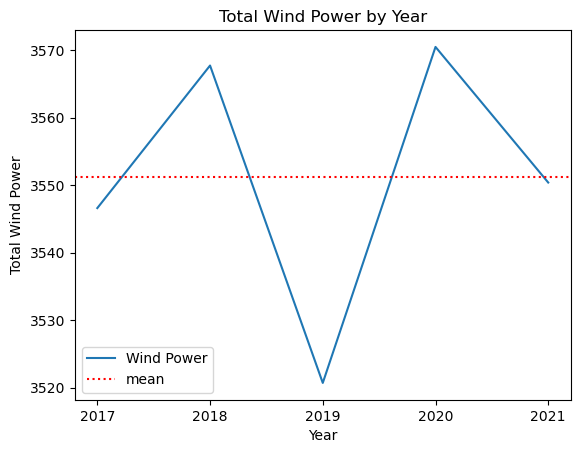

In [606]:
#2. Wind power by Year
plt.plot(year_grouped)
plt.axhline(y=np.nanmean(year_grouped), linestyle='dotted',color='r')
plt.xticks(np.arange(2017,2022,1))
plt.title('Total Wind Power by Year')
plt.xlabel('Year')
plt.ylabel('Total Wind Power')
plt.legend(['Wind Power','mean'], loc="lower left")

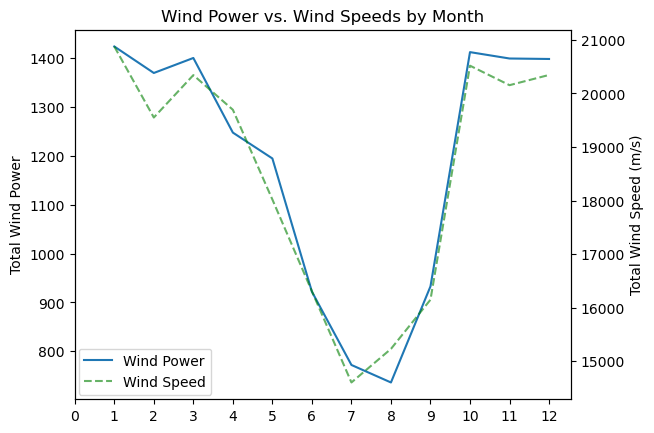

In [607]:
#3. Wind power vs. Wind speed by Month
fig, ax1 = plt.subplots()
ax1.plot(month_grouped)
ax2 = ax1.twinx()
ax2.plot(wind_month,color='g',alpha=0.6,linestyle='dashed')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.title('Wind Power vs. Wind Speeds by Month')
plt.xlabel('Month')
ax1.set_ylabel('Total Wind Power')
ax2.set_ylabel('Total Wind Speed (m/s)')
fig.legend(['Wind Power','Wind Speed'],loc='lower left', bbox_to_anchor=(0.120,0.105))

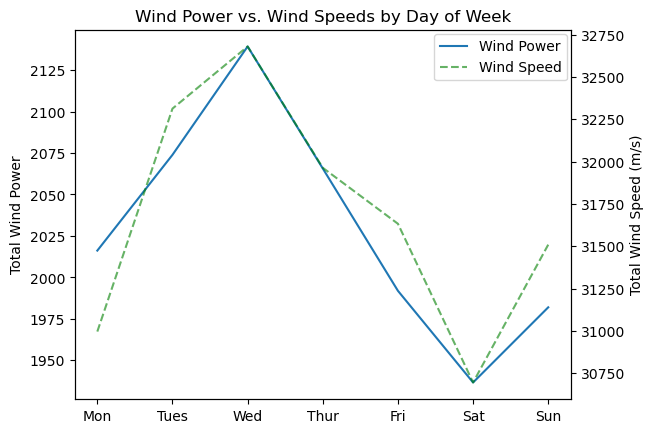

In [608]:
#4. Wind power vs. Wind speed by Day of week
fig, ax1 = plt.subplots()
ax1.plot(weekday_grouped)
ax2 = ax1.twinx()
ax2.plot(wind_day,color='g',alpha=0.6,linestyle='dashed')
plt.xticks([0,1,2,3,4,5,6],['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.title('Wind Power vs. Wind Speeds by Day of Week')
plt.xlabel('Day of Week')
ax1.set_ylabel('Total Wind Power')
ax2.set_ylabel('Total Wind Speed (m/s)')
fig.legend(['Wind Power','Wind Speed'],loc='upper right', bbox_to_anchor=(0.905,0.885))
# ax1.legend(['Wind Power'], loc="lower left")
# ax2.legend(['Wind Speed'], loc="lower left")

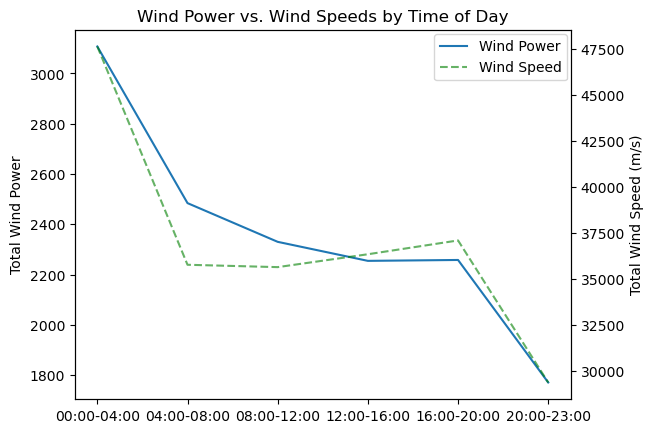

In [609]:
#5. Wind power vs. Wind speed by Time of day
fig, ax1 = plt.subplots()
ax1.plot(timeofday_grouped)
ax2 = ax1.twinx()
ax2.plot(wind_time,color='g',alpha=0.6,linestyle='dashed')
plt.xticks([0,1,2,3,4,5],['00:00-04:00','04:00-08:00','08:00-12:00','12:00-16:00','16:00-20:00','20:00-23:00'])
plt.title('Wind Power vs. Wind Speeds by Time of Day')
plt.xlabel('Time of Day')
ax1.set_ylabel('Total Wind Power')
ax2.set_ylabel('Total Wind Speed (m/s)')
fig.legend(['Wind Power','Wind Speed'],loc='upper right', bbox_to_anchor=(0.905,0.885))
# ax1.legend(['Wind Power'], loc="lower left")
# ax2.legend(['Wind Speed'], loc="lower left")

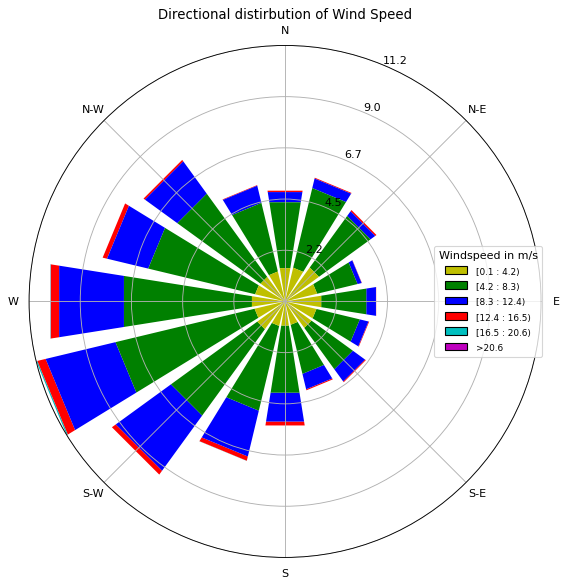

In [610]:
#6. Distribution of wind direction and speed
ax = WindroseAxes.from_ax()
ax.bar(loc1_train['winddirection_100m'],loc1_train['windspeed_100m'], normed=True, opening=0.8,colors=('y','g','b','r','c','m'))
ax.set_title('Directional distirbution of Wind Speed')
ax.set_legend(title='Windspeed in m/s',loc=7)

# MODELING

<Axes: >

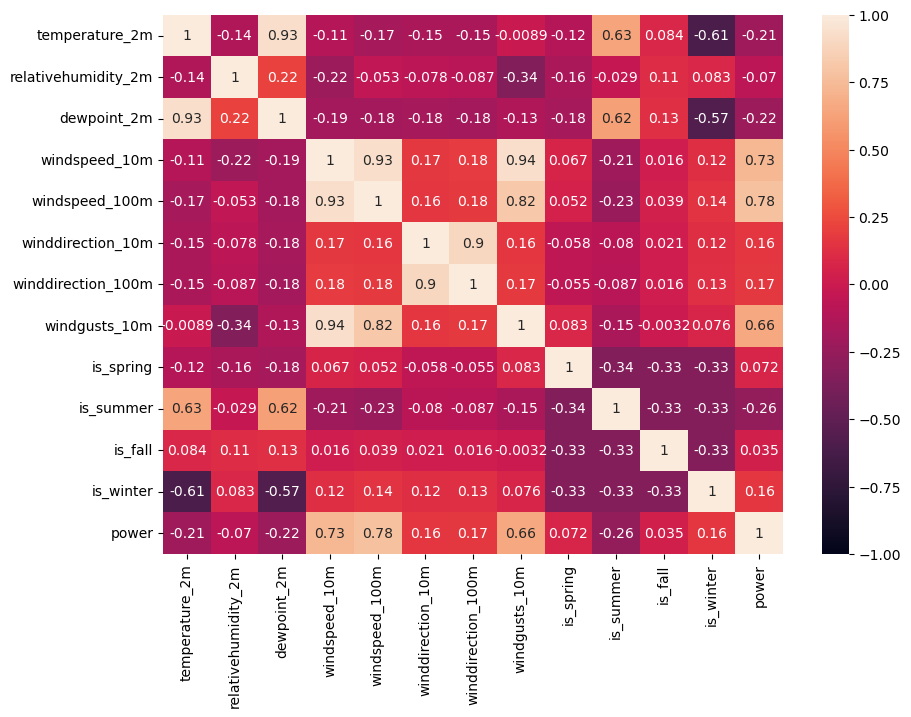

In [611]:
#Correlation heatmaps for feature selection
columns = ['temperature_2m','relativehumidity_2m','dewpoint_2m','windspeed_10m','windspeed_100m','winddirection_10m','winddirection_100m','windgusts_10m','is_spring','is_summer','is_fall','is_winter','power']
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df1[columns].corr(),vmin=-1,vmax=1,annot=True)

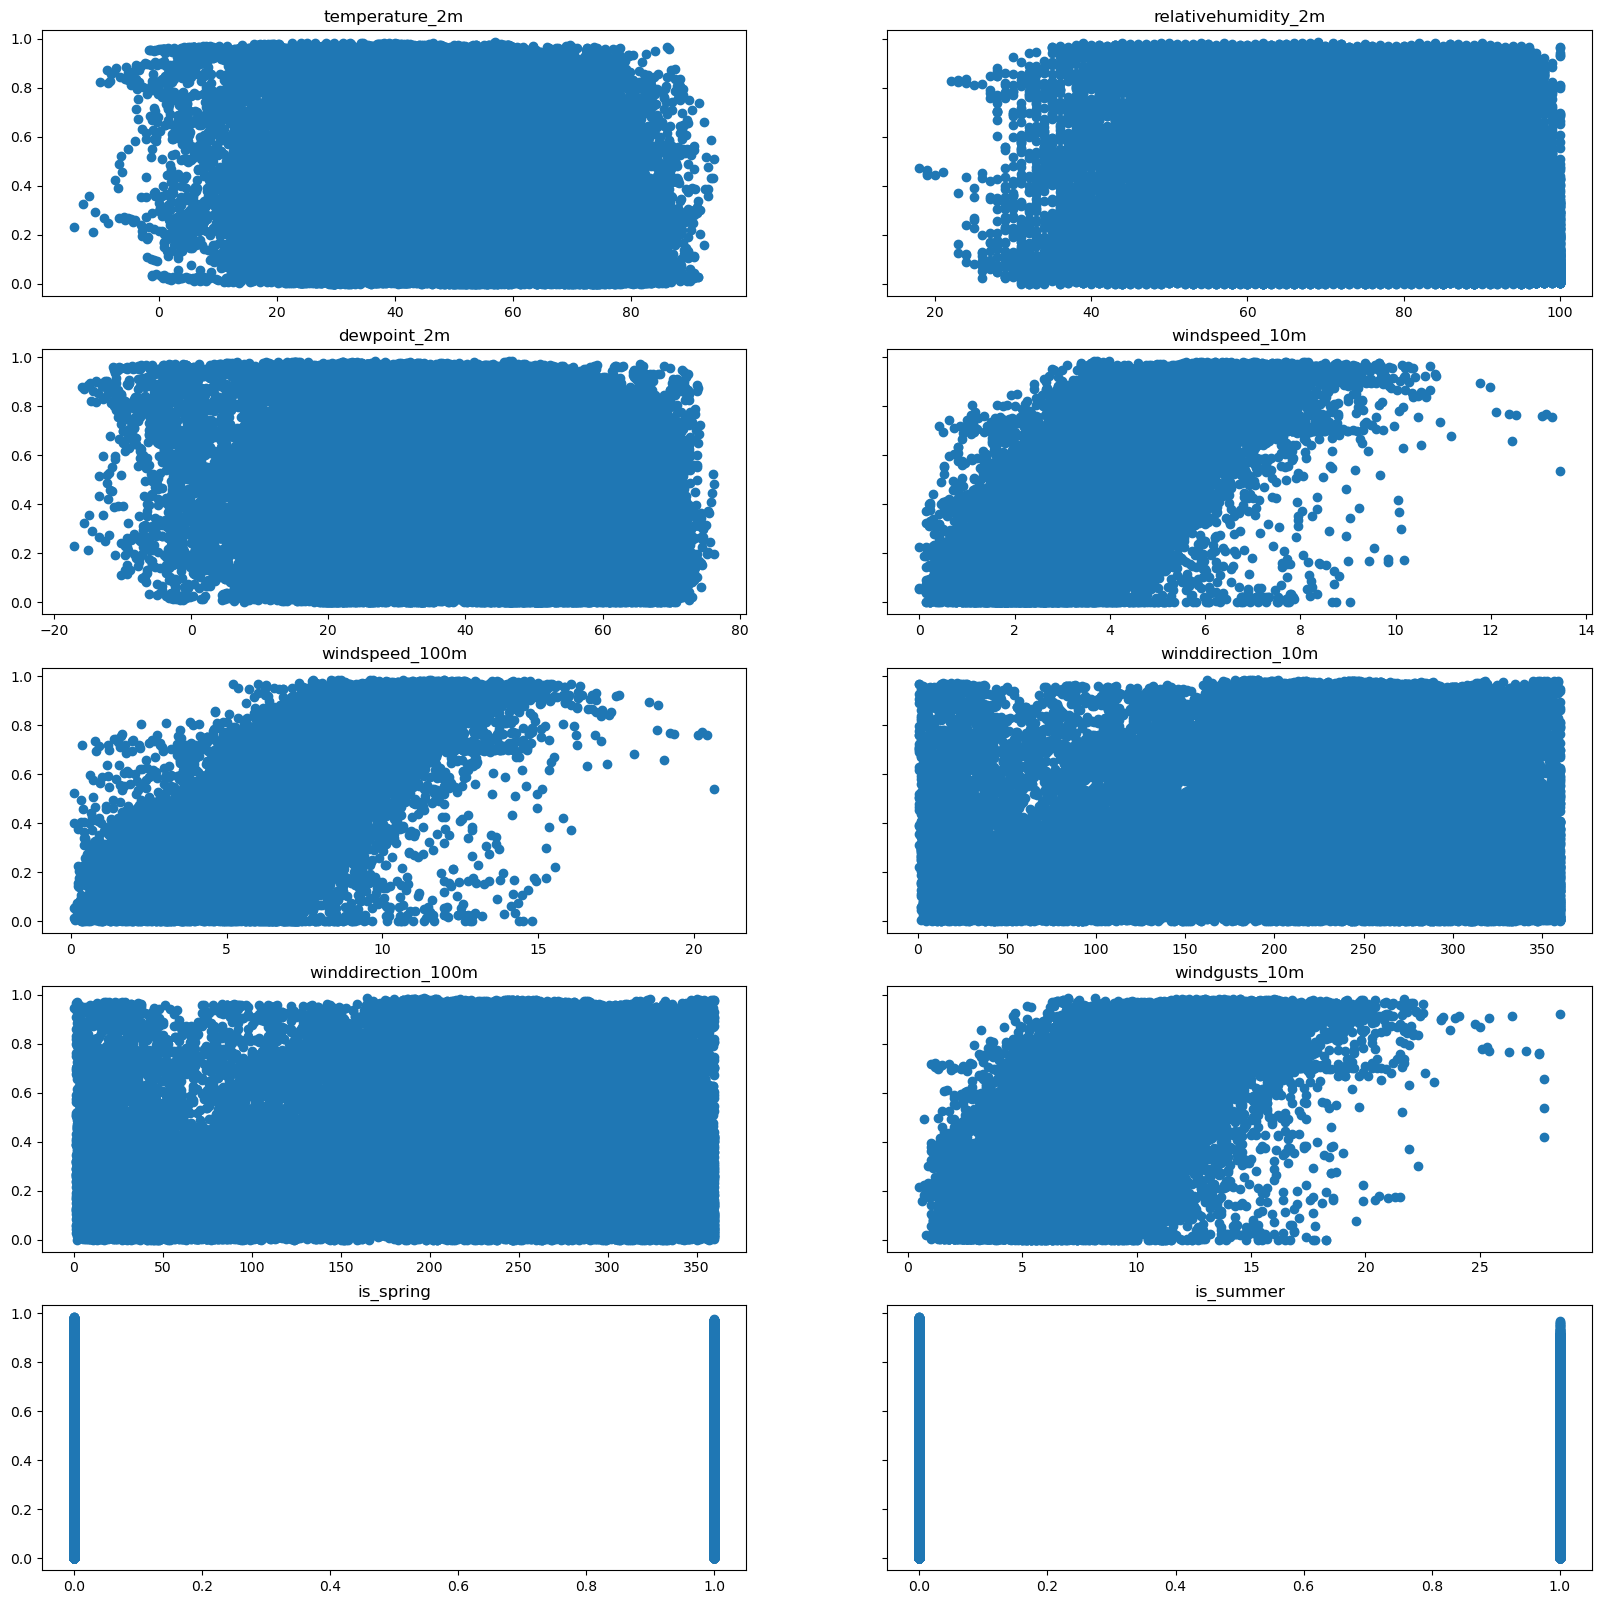

In [612]:
#Correlation subplots to visualize features relationship with power
nrows = 5
ncols = 2
fig, ax = plt.subplots(nrows,ncols, figsize=(20,20),sharey='all')

i=0
while i<8:
    for x in range(nrows):
        for y in range(ncols):
            ax[x,y].scatter(loc1_train[columns[i]],loc1_train['power'])
            ax[x,y].title.set_text(columns[i])
            i+=1

In [613]:
#1. Statsmodel
import statsmodels.formula.api as smf

model = smf.ols(data=loc1_train, formula="power ~ windspeed_100m + windspeed_10m + windgusts_10m + temperature_2m + winddirection_100m + is_spring + is_summer + is_fall + is_winter")
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     7051.
Date:                Wed, 07 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:31:49   Log-Likelihood:                 11001.
No. Observations:               35040   AIC:                        -2.198e+04
Df Residuals:                   35031   BIC:                        -2.191e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0779      0.004    -20.147      0.000      -0.085      -0.070
windspeed_100m         0.0805      0.001     73.709      0.000       0.078       0.083
windspeed_10m         -0.0323      0.003    -11.081      0.000      -0.038      -0.027
windgusts_10m          0.0159      0.001     18.373      0.000       0.014       0.018
temperature_2m        -0.0007   7.95e-05     -8.584      0.000      -0.001      -0.001
winddirection_100m  8.715e-05   9.96e-06      8.748      0.000    6.76e-05       0.000
is_spring             -0.0133      0.002     -7.427      0.000      -0.017      -0.010
is_summer             -0.0481      0.003    -16.384      0.000      -0.054      -0.042
is_fall               -0.0076      0.002     -3.751      0.000      -0.012      -0.004
is_winter             -0.0088      0.002     -4.320      0.000      -0.013      -0.005
==============================================================================
Omnibus:                     1152.473   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2797.904
Skew:                          -0.157   Prob(JB):                         0.00
Kurtosis:                       4.348   Cond. No.                     1.56e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [614]:
#Evaluating Model scores
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(
    loc1_train['windspeed_100m'], loc1_train['power'])

# get predictions for training and test power
# training
train_regr = intercept + slope*loc1_train['windspeed_100m']
# test
test_regr = intercept + slope*loc1_test['windspeed_100m']


eval_df = pd.DataFrame({"R2": [metrics.r2_score(loc1_train['power'], train_regr), metrics.r2_score(loc1_test['power'], test_regr)],
                        "MAE": [metrics.mean_absolute_error(loc1_train['power'], train_regr), metrics.mean_absolute_error(loc1_test['power'], test_regr)],
                        "RMSE":[metrics.mean_squared_error(loc1_train['power'],train_regr), metrics.mean_squared_error(loc1_test['power'],test_regr)]},
                       index=['training', 'test'])

eval_df

,R2,MAE,RMSE
training,0.604147,0.142067,0.032288
test,0.613161,0.148694,0.034573


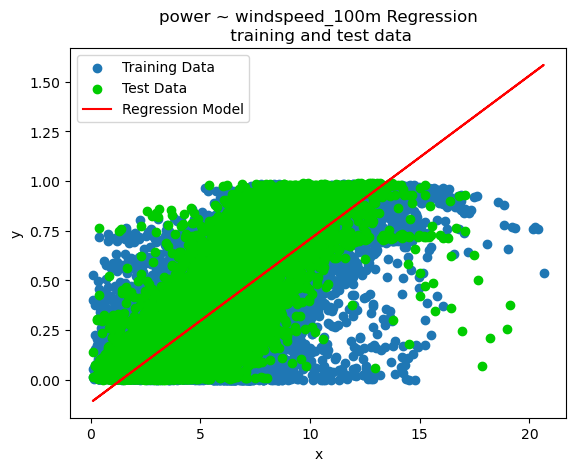

In [615]:
plt.scatter(loc1_train['windspeed_100m'], loc1_train['power'], label='Training Data')
plt.scatter(loc1_test['windspeed_100m'], loc1_test['power'], color='#00CC00', label='Test Data')
plt.plot(loc1_train['windspeed_100m'], intercept + slope*loc1_train['windspeed_100m'], color='red', label='Regression Model')
plt.title("power ~ windspeed_100m Regression\n training and test data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [616]:
#2. Scikit learn Model
tss = TimeSeriesSplit(n_splits = 4)
df2 = df1.set_index('year')
df2.sort_index(inplace=True)

#Selecting features
X = df2.drop(labels=['power','time','timeofday','relativehumidity_2m'], axis=1)
y = df2['power']

#Creating train & test data using TimeSeriesSplit function
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#Fitting Model
model = LinearRegression()
model.fit(X_train,y_train)

#Predictions
predictions = model.predict(X_test)
predictions

array([0.004528  , 0.08257098, 0.15049969, ..., 0.05294096, 0.22960133,
       0.26800155])

In [617]:
#Evaluating Model scores
MAE = mean_absolute_error(y_test,predictions)
MSE = mean_squared_error(y_test,predictions)
RMSE = np.sqrt(MSE)

print("MAE: %f" % (MAE))
print("RMSE: %f" % (RMSE))

MAE: 0.144918
RMSE: 0.181866


# VALIDATION

In [618]:
#Transforming test data and predictions data for visualization & validation

#reset index on y_test data series
y_test_data = y_test.reset_index(drop=True)
pred = pd.Series(predictions)
y_test_data

0       0.1669
1       0.1593
2       0.1517
3       0.1442
4       0.1366
         ...  
8755    0.1796
8756    0.2066
8757    0.2336
8758    0.2606
8759    0.2877
Name: power, Length: 8760, dtype: float64

In [619]:
pred

0       0.004528
1       0.082571
2       0.150500
3       0.225624
4       0.234193
          ...   
8755    0.043421
8756    0.215445
8757    0.052941
8758    0.229601
8759    0.268002
Length: 8760, dtype: float64

In [620]:
#Creating residuals dataframe including test, predicted and residual data
res_df = pd.DataFrame({'y_test_data':y_test_data,
                      'predicted':pred,
                      'res':y_test_data - pred})
res_df
np.mean(res_df['res'])

0.01956265520156025

In [621]:
#1 Bokeh scatter plot with y_test_data, predictions and residuals
p = figure(title='Actual vs Predicted Residual',width=1000, height=500)

# add a circle renderer with a size, color, and alpha
p.circle(y_test_data.index, y_test_data, size=3, color="blue", alpha=0.5, legend_label='y_test')
p.circle(pred.index, pred, size=3, color="green", alpha=0.5,legend_label='predicted')
p.circle(res_df.index, res_df['res'], size=3, color="black", alpha=0.5,legend_label='residual')
p.line(pred.index,0.3,line_width=2,color='red',legend_label='+ve threshold')
p.line(pred.index,-0.3,line_width=2,color='red', legend_label='-ve threshold')

#creating legend
p.legend.location = "top_left"
p.legend.click_policy="hide"

# show the results
show(p)

In [622]:
# Setting index as month for predicted y test data. Each month represents 730 hours or rows.
months =[1,2,3,4,5,6,7,8,9,10,11,12]
x = 730
res = []
for i in months:
    for item in range(x):
        res.append(i)

In [623]:
#Creating a dataframe of the predicted y test values and grouping by month from above.
pred_df = pd.DataFrame(pred)
pred_df['month']=res
pred_grouped = pred_df.groupby('month')[0].agg('sum')
pred_grouped

month
1     275.722074
2     350.700581
3     367.331977
4     282.324987
5     247.487150
6     232.980903
7     191.326492
8     163.112883
9     274.971598
10    274.398812
11    344.755815
12    373.899368
Name: 0, dtype: float64

In [624]:
#Creating groupby of actual test values by month.
actuals = df1[df1['year']>2020]
actuals = actuals.drop(labels=['time','timeofday'],axis=1)
actuals_grouped = actuals.groupby('month')['power'].agg('sum')

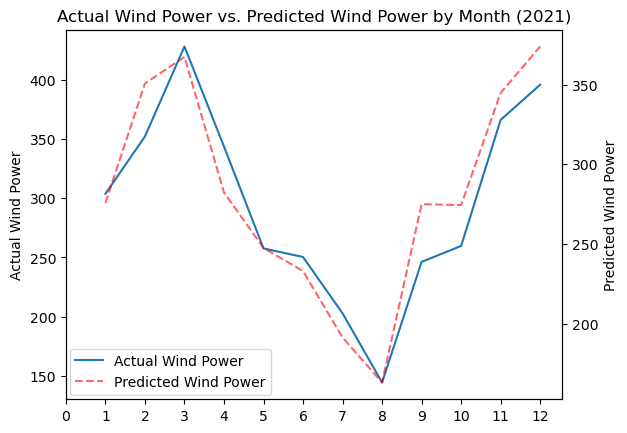

In [625]:
#2. Visualizing actual vs predicted wind power for test data (2021)
fig, ax1 = plt.subplots()
ax1.plot(actuals_grouped)
ax2 = ax1.twinx()
ax2.plot(pred_grouped,color='r',alpha=0.6,linestyle='dashed')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.title('Actual Wind Power vs. Predicted Wind Power by Month (2021)')
plt.xlabel('Month')
ax1.set_ylabel('Actual Wind Power')
ax2.set_ylabel('Predicted Wind Power')
fig.legend(['Actual Wind Power','Predicted Wind Power'],loc='lower left', bbox_to_anchor=(0.120,0.105))